# Predict Flight Delay

In [237]:
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/My Drive/Colab Notebooks/Delay_project/predict_flight_delay
#!ls

In [238]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 101)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost as xgb
from xgboost import plot_importance
from datetime import datetime
from sklearn.pipeline import Pipeline

In [239]:
%matplotlib inline  
%config InlineBackend.figure_format = 'retina' 

In [240]:
import warnings
warnings.filterwarnings("ignore")

In [241]:
# !pip install missingno
import missingno as msno

In [242]:
#!pip install shap
import shap

## Data Description

Column | Description
:---|:---
`id` | Identification number for the flight.
`dep_stn` | Departure point.
`arr_stn` | Arrival point.
`ac_code` | Aircraft Code. 
`dep_date` | Scheduled departure date.	
`arr_date` | Scheduled arrival date.
`weather` | Observed weather conditions at departure.
`hobbs_meter` | The time in hours that an aircraft has been in use.
`year_man` | Year of manufacturer for the aircraft.
`dep_country` | Departure country.
`arr_country` | Destination country.
`delay` | Number of minutes a flight was delayed.

## Data Wrangling & Visualization

In [243]:
# Dataset is already loaded below
data = pd.read_csv("train.csv")
data.head()
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           5000 non-null   object 
 1   dep_stn      5000 non-null   object 
 2   arr_stn      5000 non-null   object 
 3   ac_code      5000 non-null   object 
 4   dep_date     5000 non-null   object 
 5   arr_date     5000 non-null   object 
 6   weather      5000 non-null   object 
 7   hobbs_meter  5000 non-null   int64  
 8   year_man     5000 non-null   object 
 9   dep_country  5000 non-null   object 
 10  arr_country  5000 non-null   object 
 11  delay        5000 non-null   float64
dtypes: float64(1), int64(1), object(10)
memory usage: 468.9+ KB


,hobbs_meter,delay
count,5000.000000,5000.00000
mean,6186.797000,20.51060
std,1693.004034,12.27381
min,3329.000000,2.00000
25%,4501.000000,10.00000
50%,6099.000000,18.00000
75%,7437.000000,30.00000
max,9137.000000,49.00000


### 1. Missing value

In [244]:
NaN = data.isna().sum().sum()
print('Total Number of NaN values:' + str(NaN))

Total Number of NaN values:0


<AxesSubplot:>

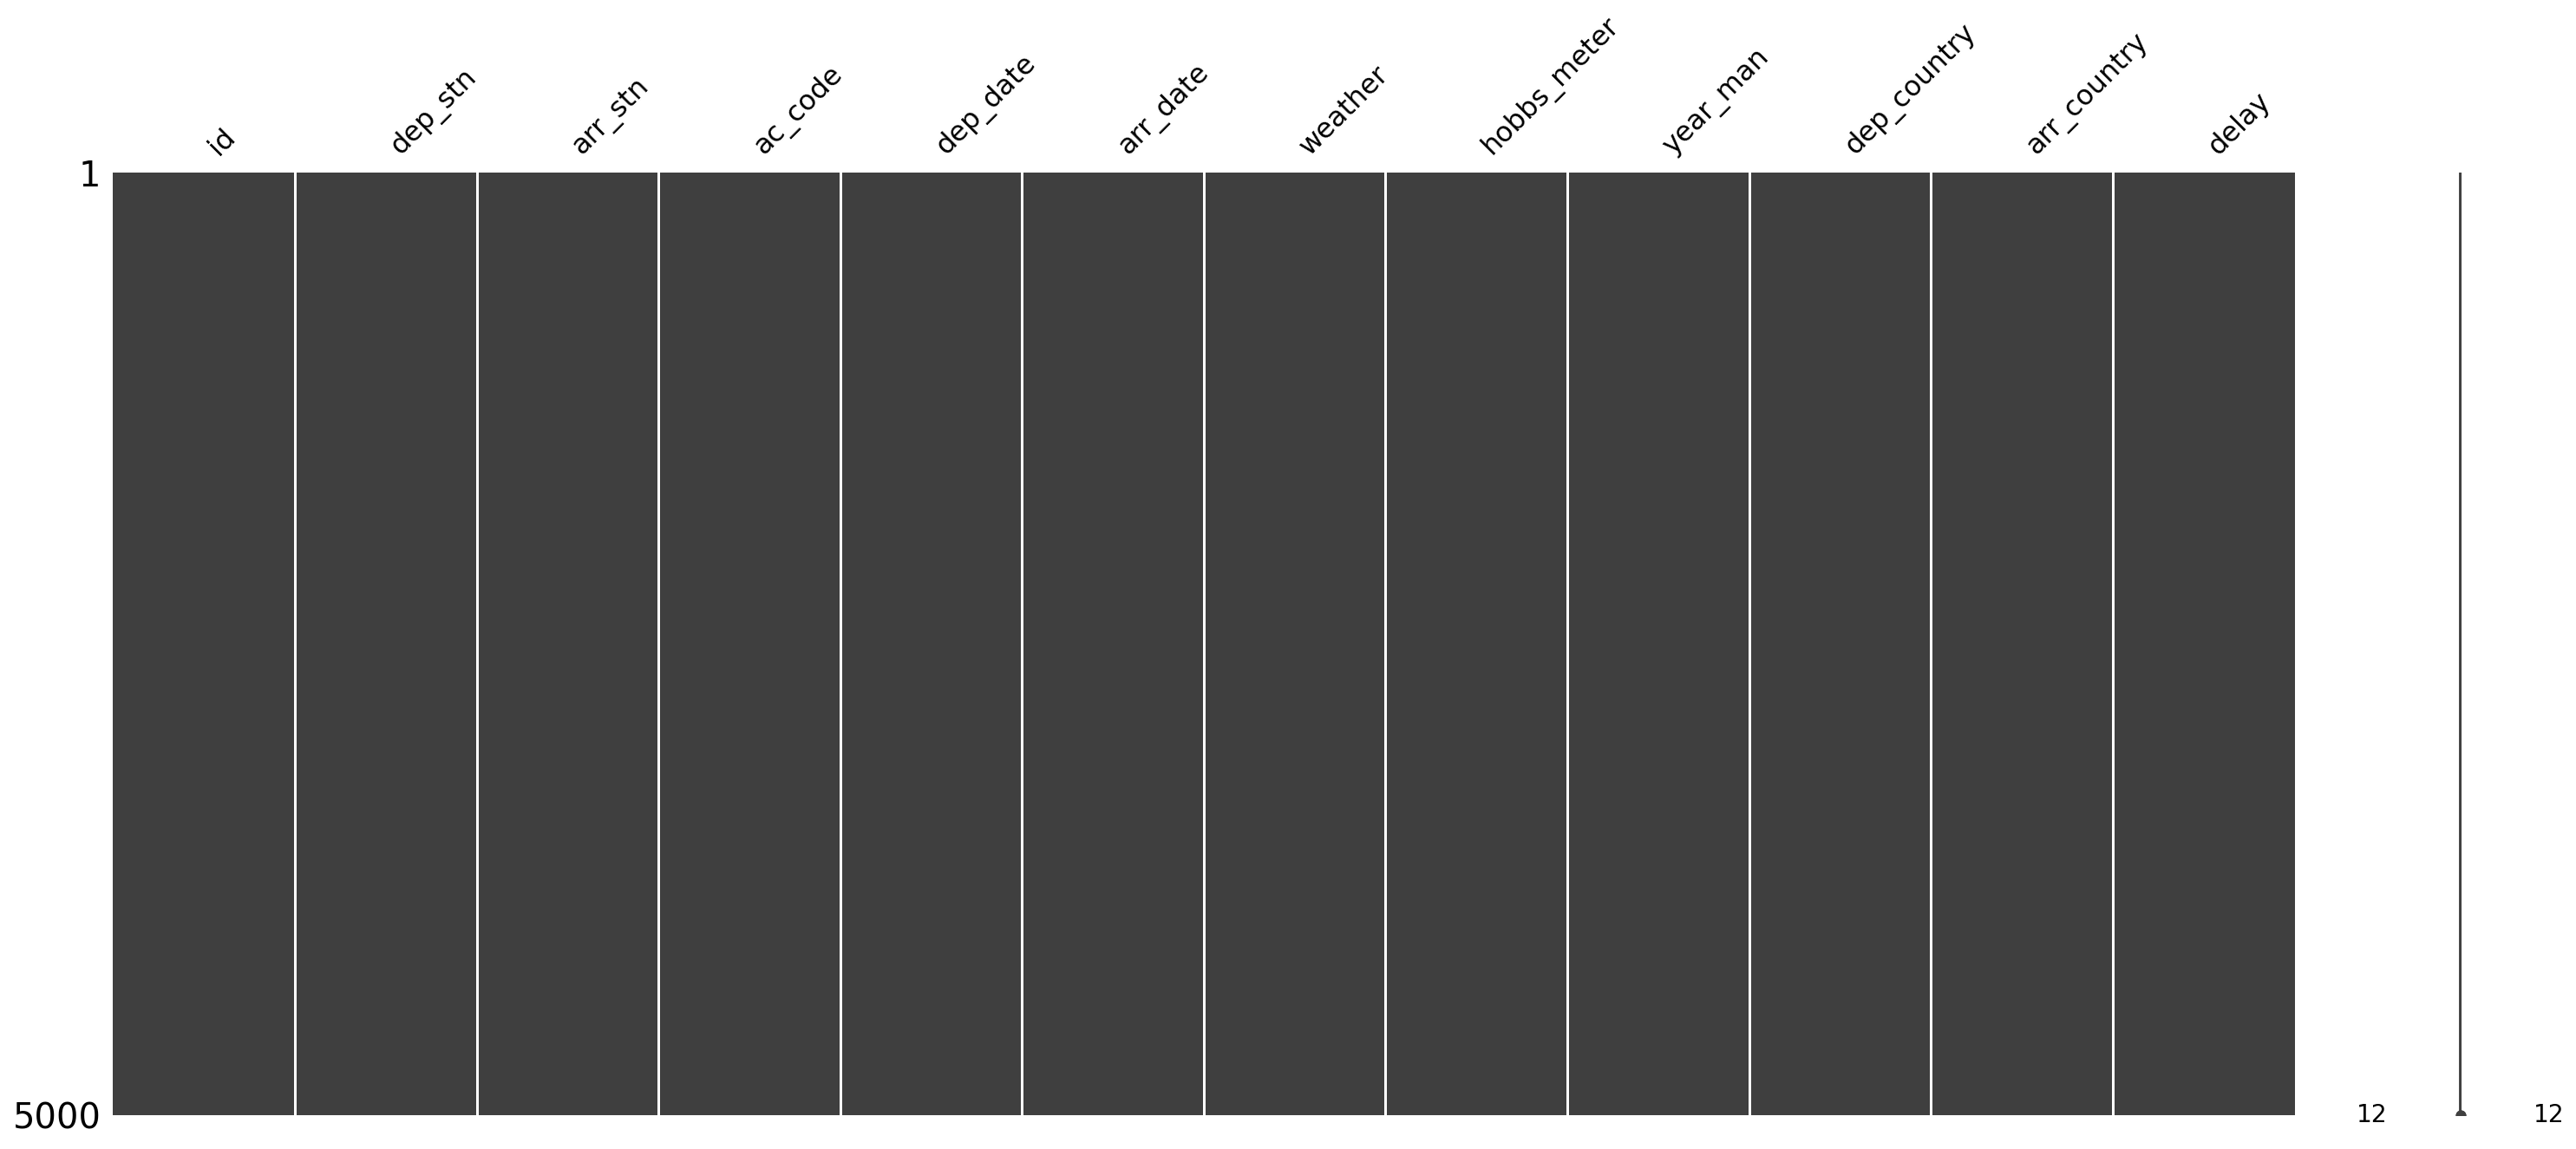

In [245]:
msno.matrix(data)

### 2. Anomalies & outlier detection
a. Detect the anomalies through EDA and feature engineering process

b. Can't directly remove the outliers derived from IQR range or z-score due to lack of domain knowledge 

c. We can compare the accuracy before and after removing the outliers if we have enough time

### 3. Datetime feature analysis

Convert into datatime type

In [246]:
data['dep_date'] = data['dep_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
data['arr_date'] = data['arr_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H.%M.%S'))
data['year_man'] = pd.to_datetime(data['year_man'])
data['year_man'] = data['year_man'].dt.year
data[['dep_date', 'arr_date', 'year_man']].dtypes

dep_date    datetime64[ns]
arr_date    datetime64[ns]
year_man             int64
dtype: object

Check if exists anomalies that departure time is later than arrival time

In [247]:
data_bad = (data['dep_date']>data['arr_date']).values.sum()
data_bad

0

Check if exists anomalies that flight duration is too long or too short 
( Assume there isn't time zone issue, but I will check it if I have more time.)

From the histogram, we find all filght durations are within reasonable range.

Also we generate filght duration as a new feature since filght duration will impact the delay time

Text(0.5, 0, 'duration in minutes')

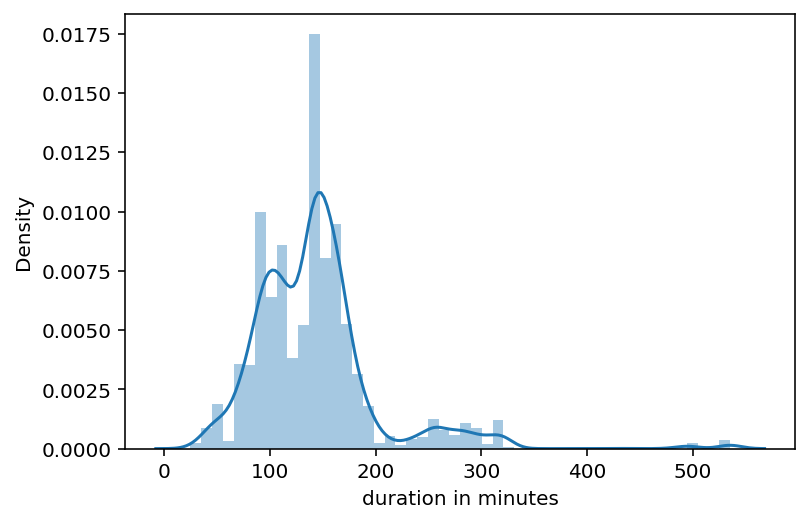

In [248]:
data['duration'] = data['arr_date'] - data['dep_date']
data['duration'] = data['duration'].dt.seconds/60
data['duration'] = round(data['duration'],1)
sns.distplot(data['duration'])
plt.xlabel('duration in minutes')

Generate the number of years of aircraft use as new numerical feature

Generate new aircraft as new binary feature

<AxesSubplot:xlabel='year_use', ylabel='delay'>

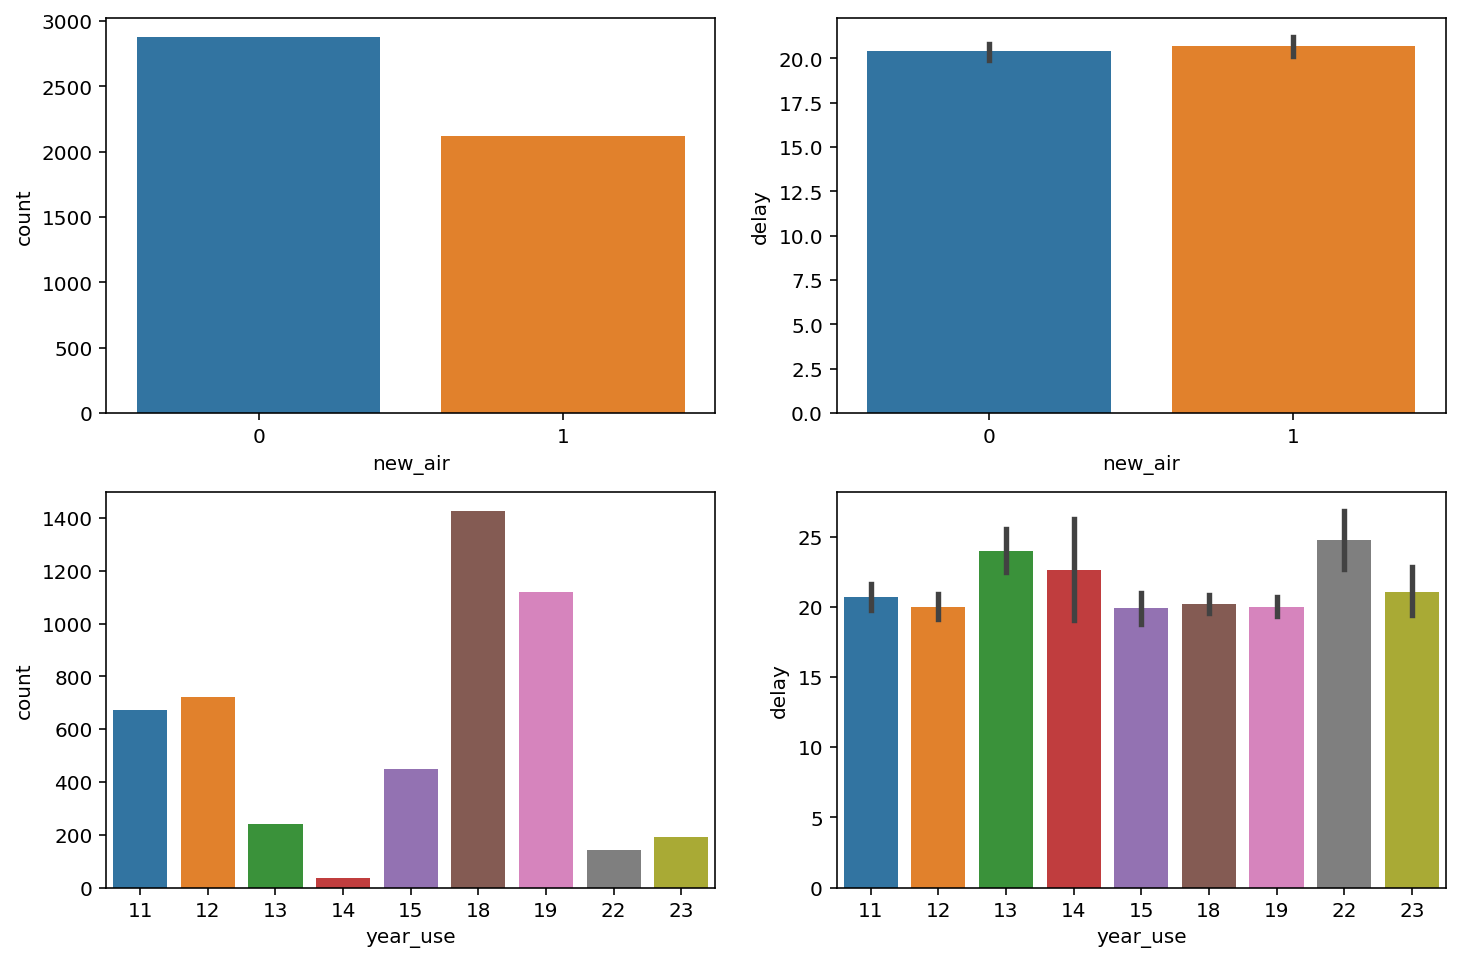

In [249]:
data['year_use'] = datetime.now().year-data['year_man']
data['new_air'] = np.where(data['year_use']<=15, 1, 0)
fig=plt.figure(figsize=(12,8))
fig.add_subplot(2,2,1)
sns.countplot(data['new_air'])
fig.add_subplot(2,2,2)
sns.barplot(data['new_air'], data['delay'])
fig.add_subplot(2,2,3)
sns.countplot(data['year_use'])
fig.add_subplot(2,2,4)
sns.barplot(data['year_use'], data['delay'])

### 3. Weather feature analysis

<AxesSubplot:xlabel='weather', ylabel='delay'>

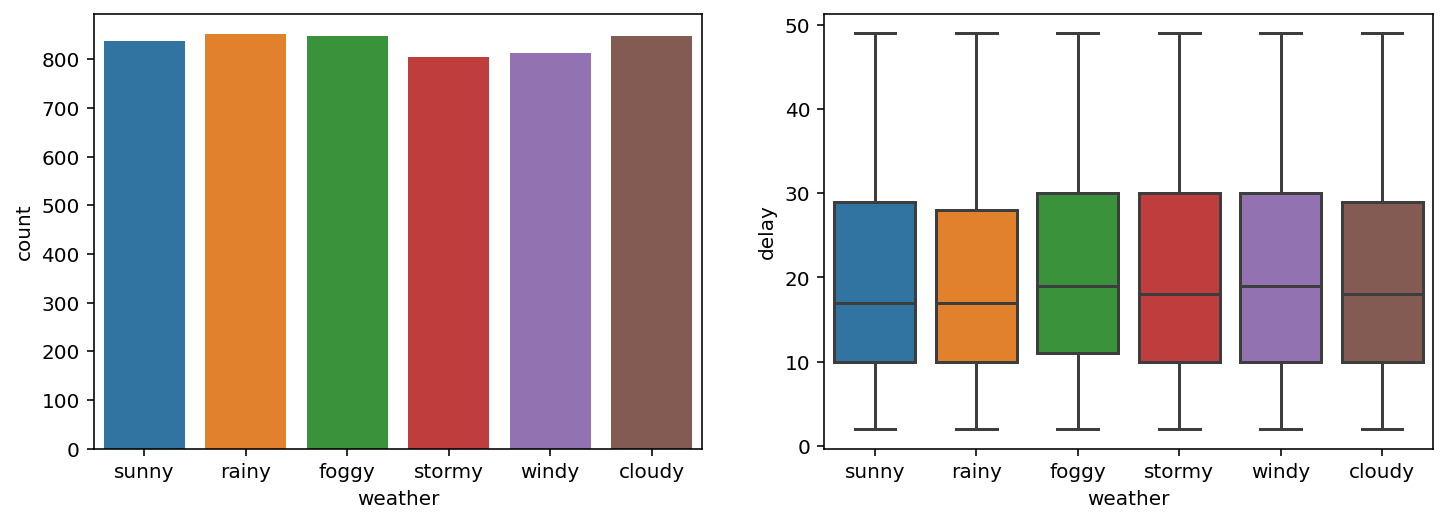

In [250]:
fig = plt.figure(figsize = (12,4))
fig.add_subplot(1,2,1)
sns.countplot(data['weather'])
fig.add_subplot(1,2,2)
sns.boxplot('weather', 'delay', data = data)

Convert weather to ordered factor

In [251]:
order_map = {'sunny': -1, 'cloudy': -1, 'windy':0, 'foggy':0, 'rainy':1,'stormy':2}
data['weather'] = data['weather'].map(order_map)

<AxesSubplot:xlabel='weather', ylabel='delay'>

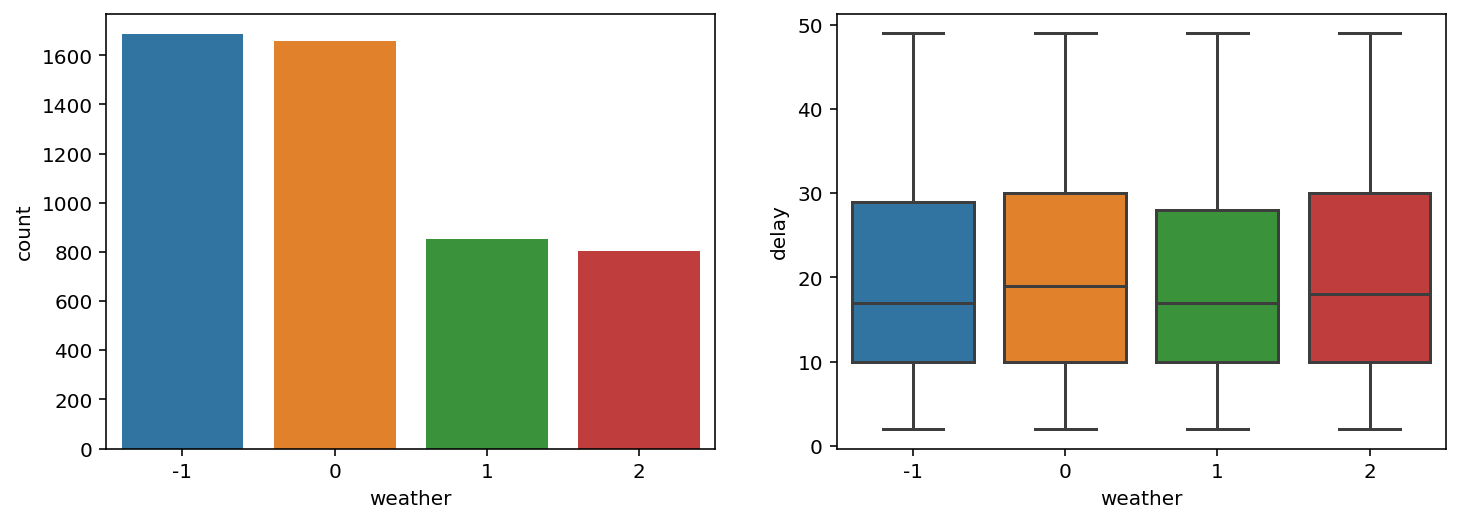

In [252]:
fig = plt.figure(figsize = (12,4))
fig.add_subplot(1,2,1)
sns.countplot(data['weather'])
fig.add_subplot(1,2,2)
sns.boxplot('weather', 'delay', data = data)

### 4. Aircraft code analysis

<AxesSubplot:xlabel='ac_code', ylabel='count'>

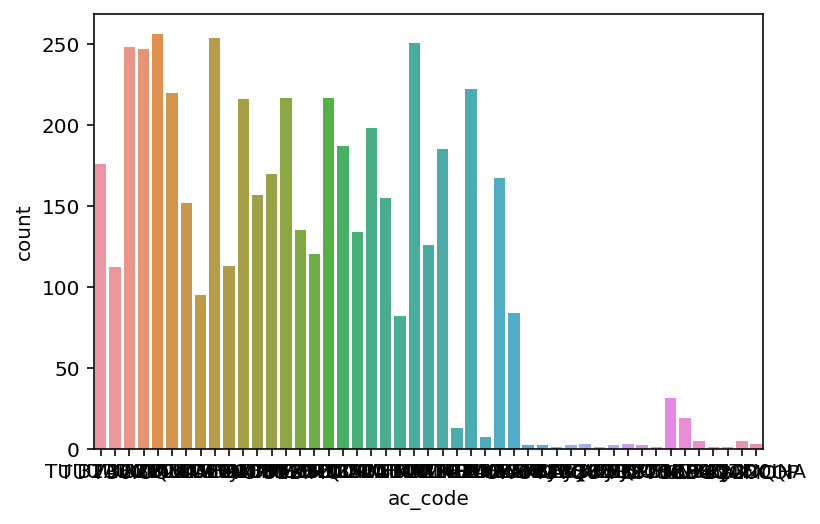

In [253]:
sns.countplot(data['ac_code'])

In [254]:
data['ac_code'].value_counts()

TU 320IMV    256
TU 320IMR    254
TU 32AIMP    251
TU 320IMU    248
TU 320IMT    247
TU 32AIMG    222
TU 32AIMH    220
TU 31BIMQ    217
TU 320IMW    217
TU 320IMS    216
TU 32AIMN    198
TU 32AIMF    187
TU 32AIML    185
TU 32AIMD    176
TU 736IOR    170
TU 32AIMM    167
TU 736IOP    157
TU 31BIMO    155
TU 31AIMJ    152
TU 736IOL    135
TU 332IFM    134
TU 332IFN    126
TU 736ION    120
TU 32AIMI    113
TU 736IOQ    112
TU 736IOK     95
TU 736IOM     84
TU 31AIMK     82
PS 738PSD     31
D4 319CQG     19
TU 32AIMC     13
TU CR9ISA      7
D4 320CQP      5
5M 343JAI      5
QS 738TSC      3
BJ 320INQ      3
BJ 320INA      3
UJ 320TCF      2
BJ 320INC      2
UG AT7LBD      2
5K 343TQY      2
UG AT7LBE      2
BJ 320INP      1
BJ 320INR      1
5M 343SUN      1
5K 345TFX      1
GW 320MQH      1
Name: ac_code, dtype: int64

Generate two aircraft type as two new categorical features based on common code

Since we can parse different dimensinonal characteristics from long text data like address (city, street, state)

<AxesSubplot:xlabel='ac_type', ylabel='delay'>

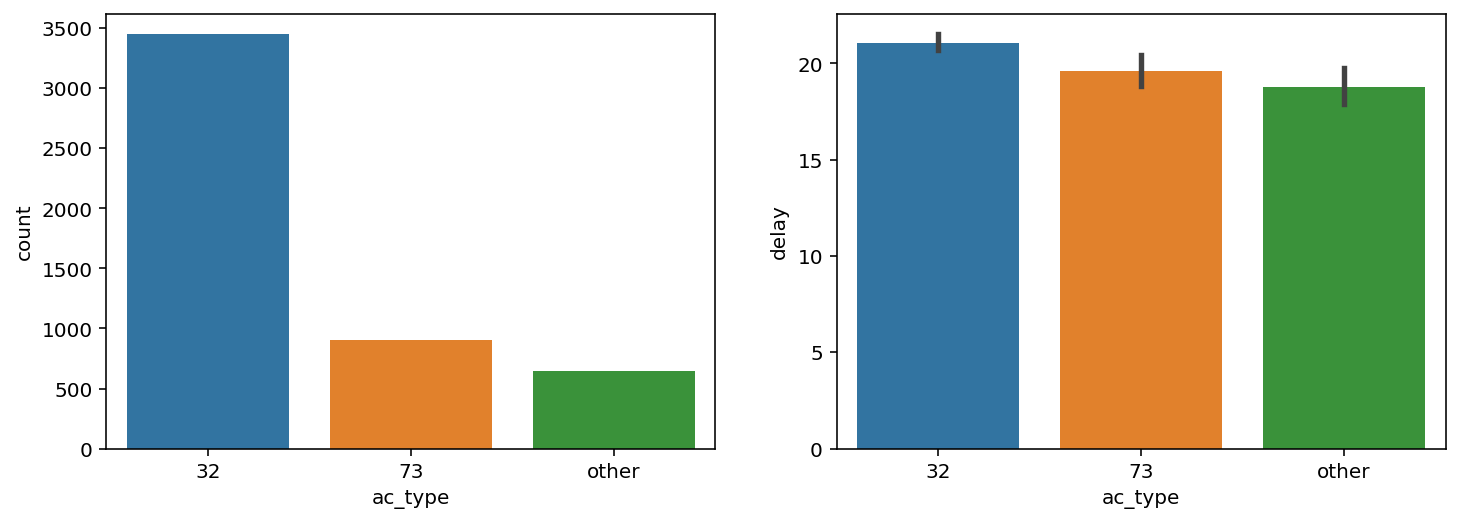

In [255]:
data['ac_type'] = np.where(data['ac_code'].str.contains('32'),'32',data['ac_code'])
data['ac_type'] = np.where(data['ac_type'].str.contains('73'),'73',data['ac_type'])
S1 = ~ data['ac_type'].str.contains('32')
S2 = ~ data['ac_type'].str.contains('73')
data['ac_type'] = np.where(S1&S2,'other',data['ac_type'])
fig = plt.figure(figsize = (12,4))
fig.add_subplot(1,2,1)
sns.countplot(data['ac_type'])
fig.add_subplot(1,2,2)
sns.barplot(data['ac_type'],data['delay'])

### 5. dep_country and arr_country analysis

Divide aircraft routes into international and domestic flights

Generate international as a new binary feature

<AxesSubplot:xlabel='international', ylabel='delay'>

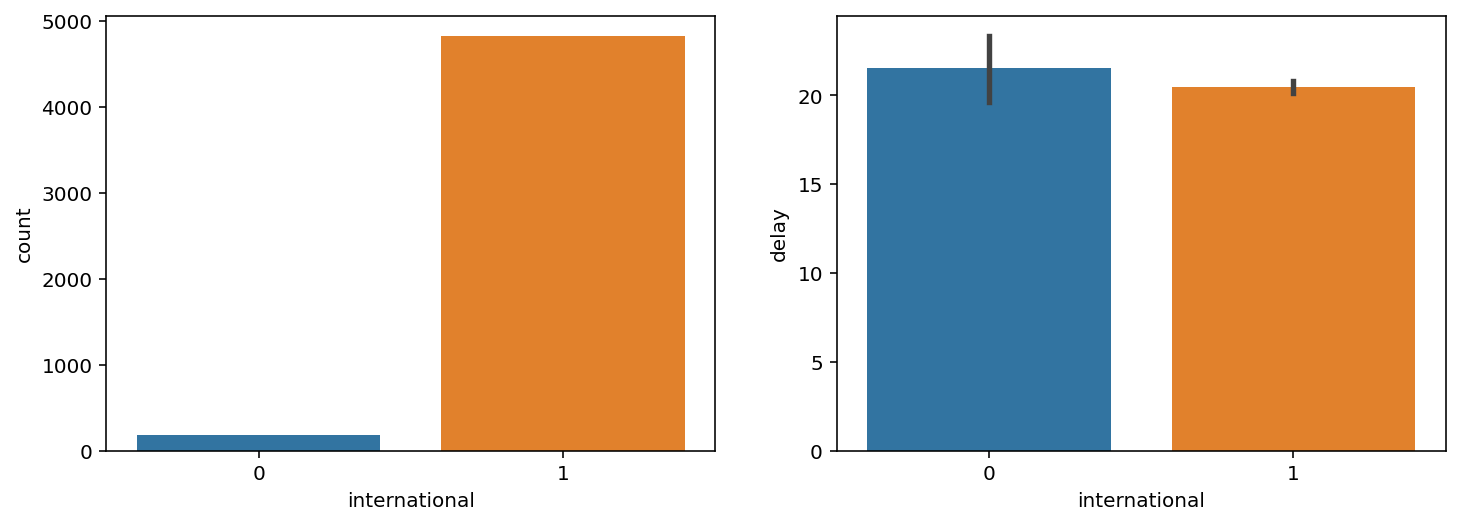

In [256]:
S3 = data['dep_country'] != data['arr_country']
data['international'] = np.where(S3,1,0)
fig = plt.figure(figsize = (12,4))
fig.add_subplot(1,2,1)
sns.countplot(data['international'])
fig.add_subplot(1,2,2)
sns.barplot(data['international'],data['delay'])

### 6. Check seasonality effect by week, month, night

In [257]:
# create a new feature called dep_night
data['dep_night'] = ~data['dep_date'].dt.hour.isin(np.arange(6,18))
order_map2 = {False: 0, True: 1}
data['dep_night'] = data['dep_night'].map(order_map2)
data['dep_month'] = data['dep_date'].dt.month

dw_mapping={
    0: 'Mon', 
    1: 'Tue', 
    2: 'Wed', 
    3: 'Thu', 
    4: 'Fri',
    5: 'Sat', 
    6: 'Sun'
} 
data['dep_week'] = data['dep_date'].dt.weekday.map(dw_mapping)

dw_mapping2={
    0: '0', 
    1: '0', 
    2: '0', 
    3: '0', 
    4: '0',
    5: '1', 
    6: '1'
} 
data['dep_weekend'] = data['dep_date'].dt.weekday.map(dw_mapping2)

<AxesSubplot:xlabel='dep_weekend', ylabel='delay'>

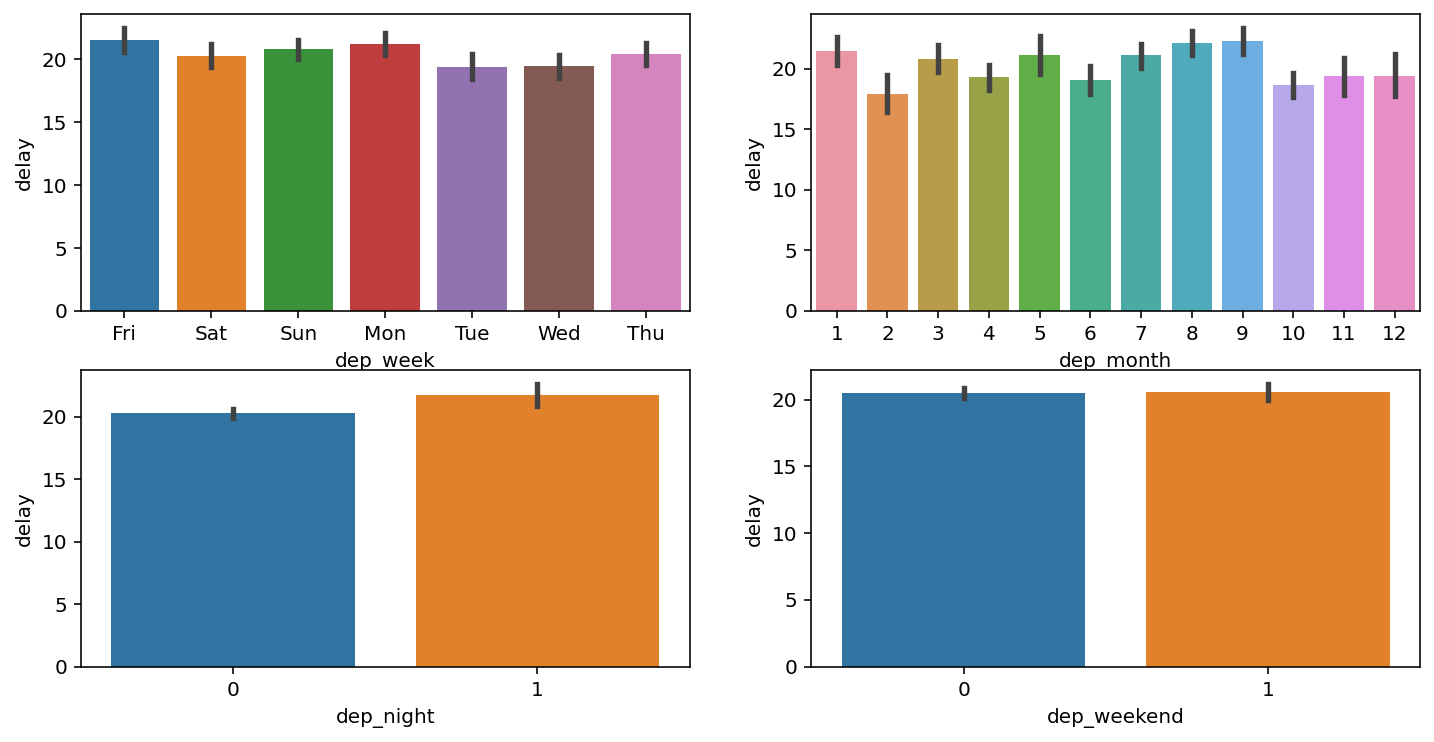

In [258]:
fig = plt.figure(figsize = (12,6))
fig.add_subplot(2,2,1)
sns.barplot('dep_week', 'delay', data = data)
fig.add_subplot(2,2,2)
sns.barplot('dep_month','delay', data = data)
fig.add_subplot(2,2,3)
sns.barplot('dep_night','delay', data = data)
fig.add_subplot(2,2,4)
sns.barplot('dep_weekend','delay', data = data)

### 7. Dep_airport analysis

Generate number of lines in dep_stn as a new feature

<AxesSubplot:xlabel='num_lines', ylabel='delay'>

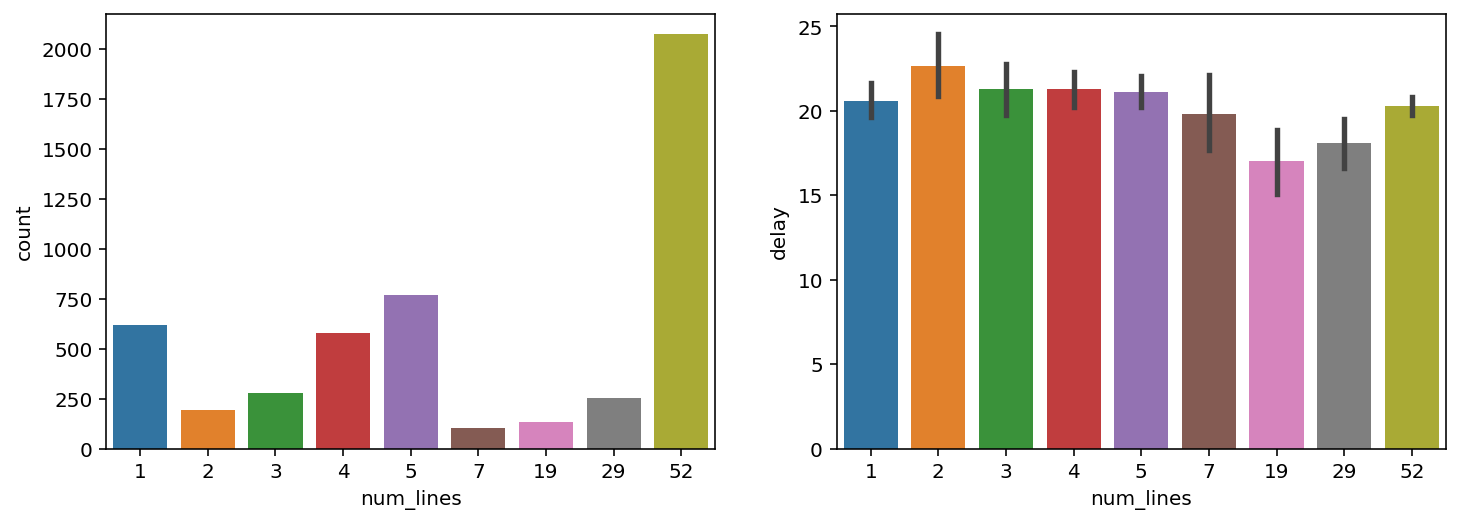

In [259]:
data['num_lines'] = data.groupby(['dep_stn'])['arr_stn'].transform('nunique')
fig = plt.figure(figsize = (12,4))
fig.add_subplot(1,2,1)
sns.countplot(data['num_lines'])
fig.add_subplot(1,2,2)
sns.barplot(data['num_lines'],data['delay'])

### 8. Previous 7 days average delay grouped by dep_country and dep_stn

In [260]:
# 因为原始dataframe正好是按照dep_date的顺序记录的(index的顺序就是dep_date的顺序）
# 所以这里可以不用order by dep_date，但是如果碰到dep_date是随意排的那种，我不知道怎么把order by加进去
data['roll_dep_stn'] = data.sort_values(by = ['dep_date']).groupby('dep_stn')[
    'delay'].rolling(7, min_periods = 1).mean().reset_index(0,drop=True)

data['roll_dep_country'] = data.sort_values(by = ['dep_date']).groupby('dep_country')[
    'delay'].rolling(7, min_periods = 1).mean().reset_index(0,drop=True)

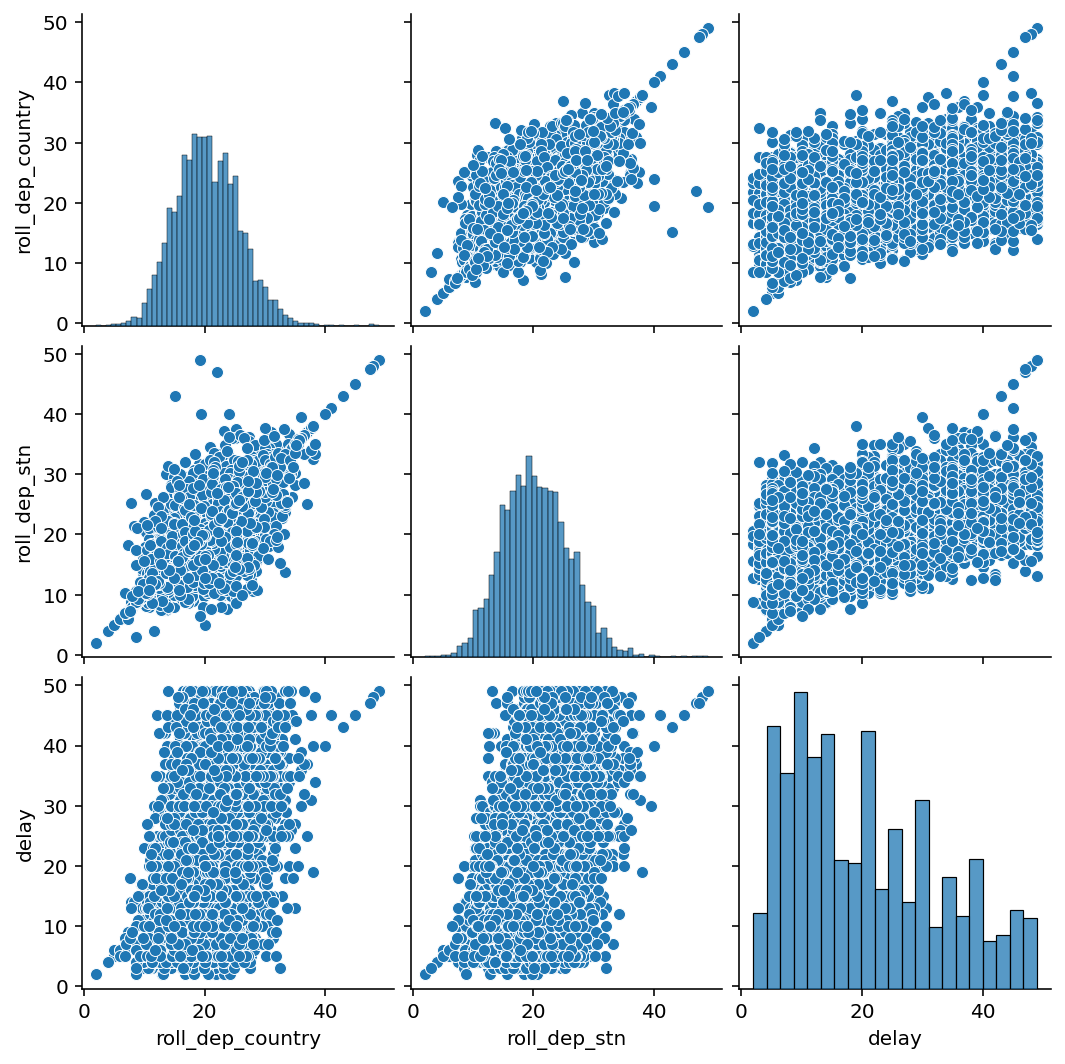

In [261]:
sns.pairplot(data[['roll_dep_country','roll_dep_stn','delay']])

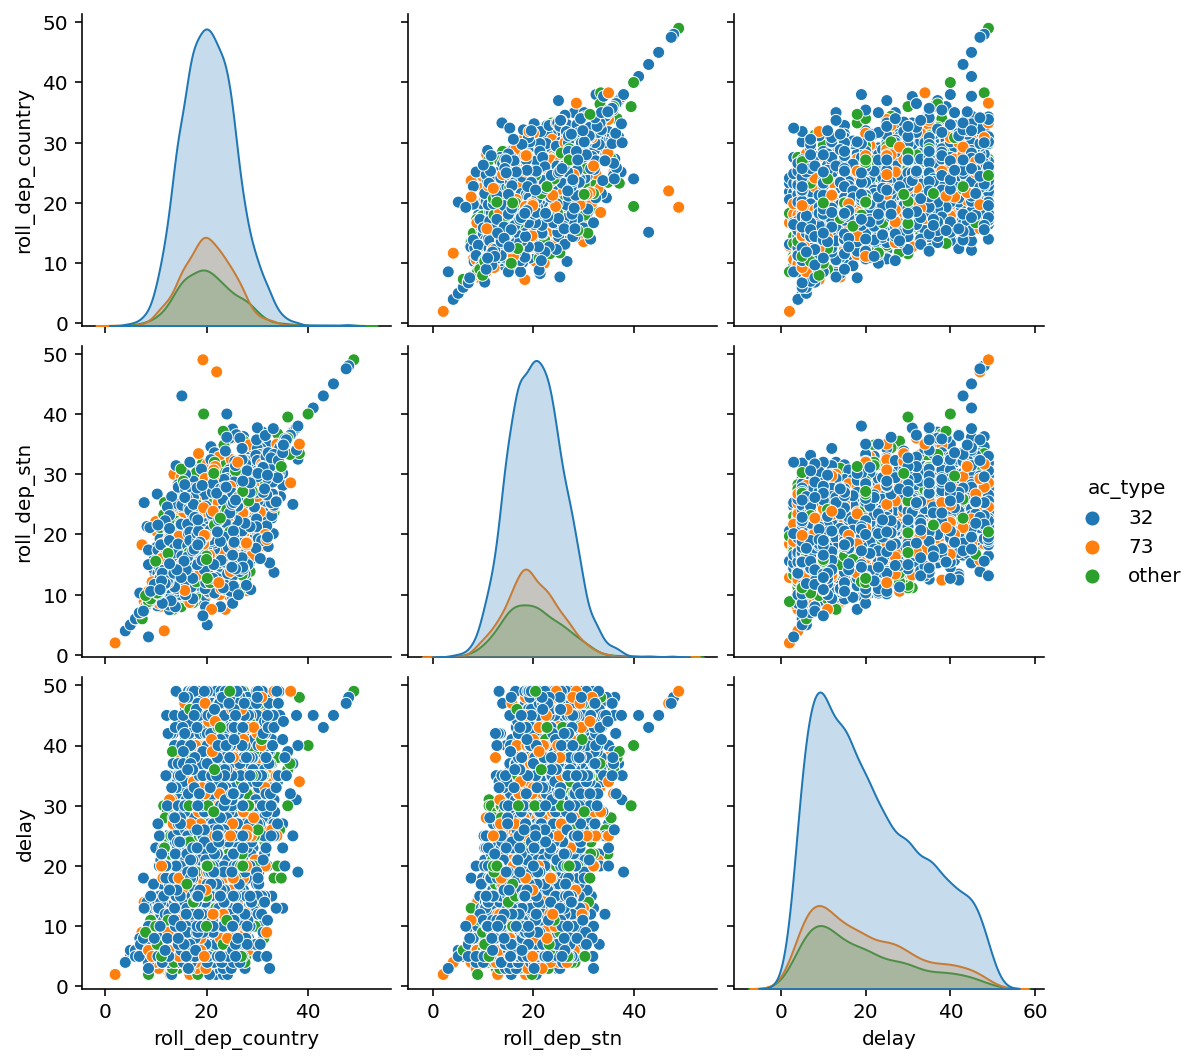

In [262]:
sns.pairplot(data, vars = ['roll_dep_country','roll_dep_stn', 'delay'], hue = 'ac_type')

In [195]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                5000 non-null   object        
 1   dep_stn           5000 non-null   object        
 2   arr_stn           5000 non-null   object        
 3   ac_code           5000 non-null   object        
 4   dep_date          5000 non-null   datetime64[ns]
 5   arr_date          5000 non-null   datetime64[ns]
 6   weather           5000 non-null   int64         
 7   hobbs_meter       5000 non-null   int64         
 8   year_man          5000 non-null   int64         
 9   dep_country       5000 non-null   object        
 10  arr_country       5000 non-null   object        
 11  delay             5000 non-null   float64       
 12  duration          5000 non-null   float64       
 13  year_use          5000 non-null   int64         
 14  new_air           5000 n

### 有个问题就是 test data里面没有delay这个column，所以没法使用previous rolling

In [267]:
data_new = data[['weather','hobbs_meter','duration','year_use','new_air','ac_type','international','dep_night',
                 'dep_weekend','num_lines','roll_dep_stn', 'roll_dep_country','delay']]


In [209]:
data_new.head()

,weather,hobbs_meter,duration,year_use,new_air,ac_type,international,dep_night,dep_week,num_lines,roll_dep_stn,roll_dep_country,delay
0,-1,4390,95.0,18,0,32,1,0,Fri,52,18.000000,18.000000,18.0
1,1,5882,165.0,12,1,73,1,0,Fri,52,28.500000,28.500000,39.0
2,0,6117,140.0,11,1,32,1,0,Fri,52,23.666667,23.666667,14.0
3,-1,8941,95.0,12,1,32,1,0,Fri,4,25.000000,25.000000,25.0
4,2,4301,115.0,18,0,32,1,0,Fri,52,23.000000,23.000000,21.0


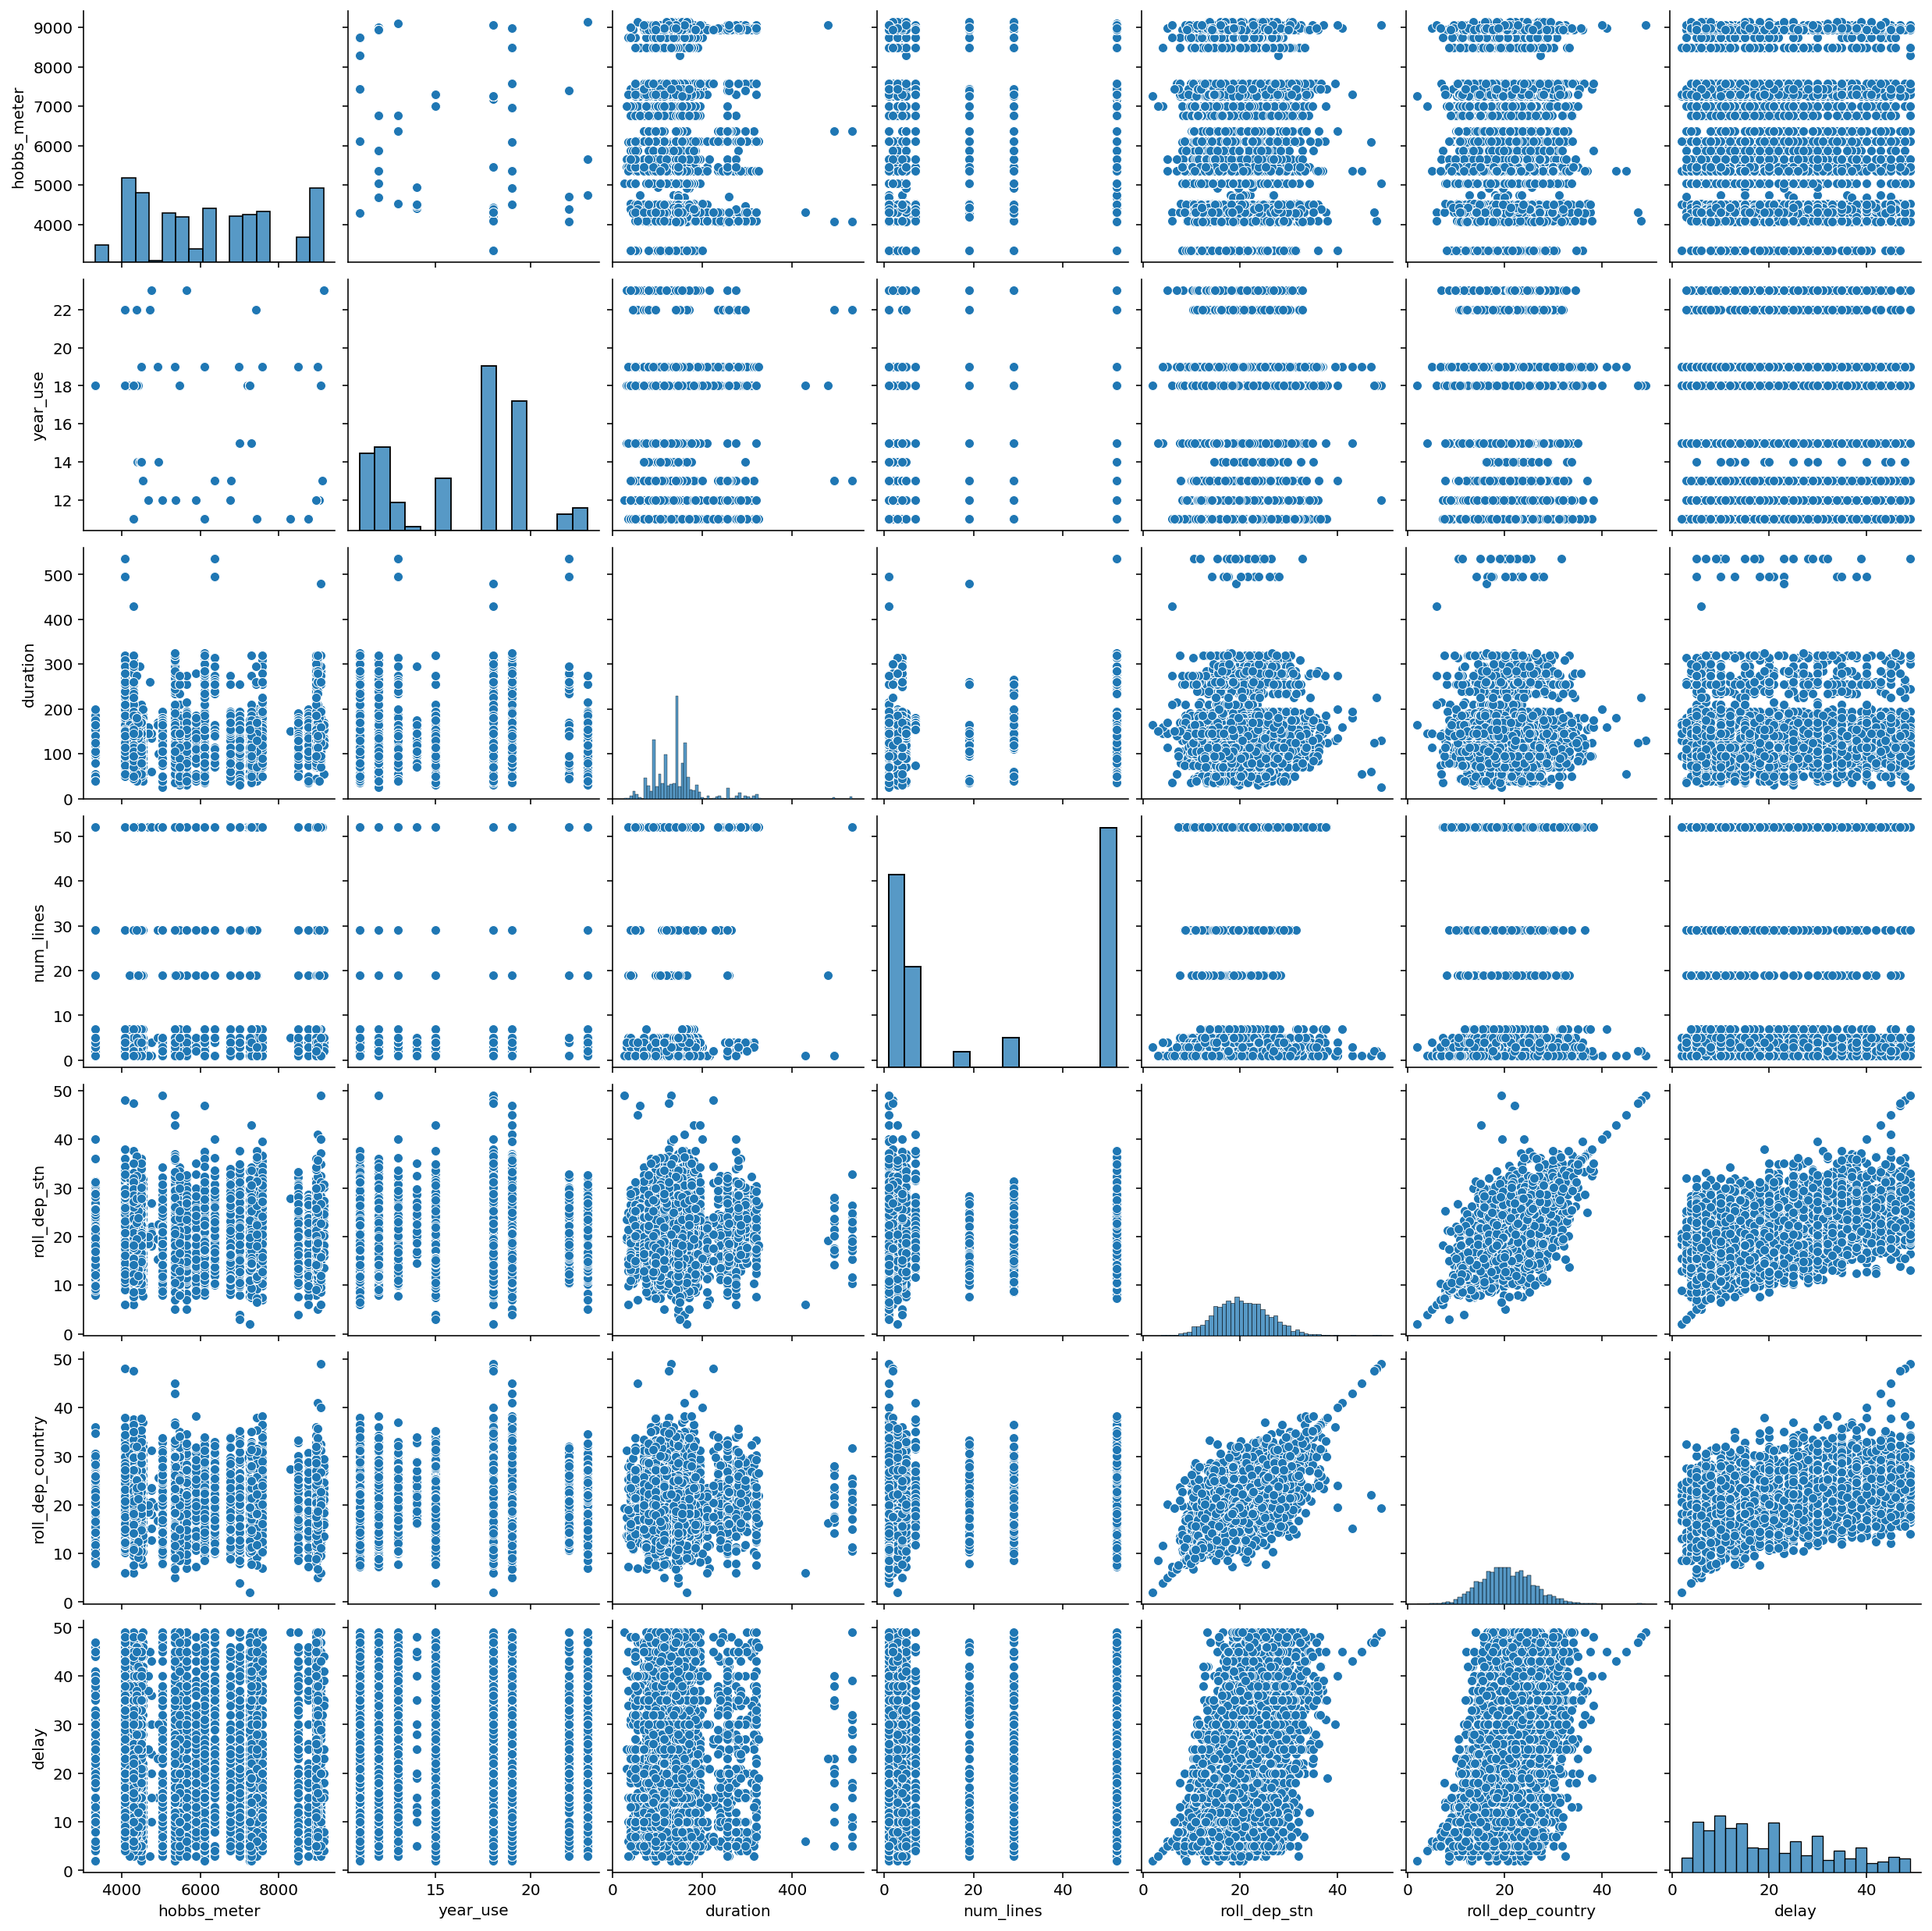

In [211]:
sns.pairplot(data_new[['weather','hobbs_meter', 'year_use', 'duration', 'num_lines','roll_dep_stn','roll_dep_country','delay']])
# don't show any linear relationship

<AxesSubplot:xlabel='dep_week', ylabel='delay'>

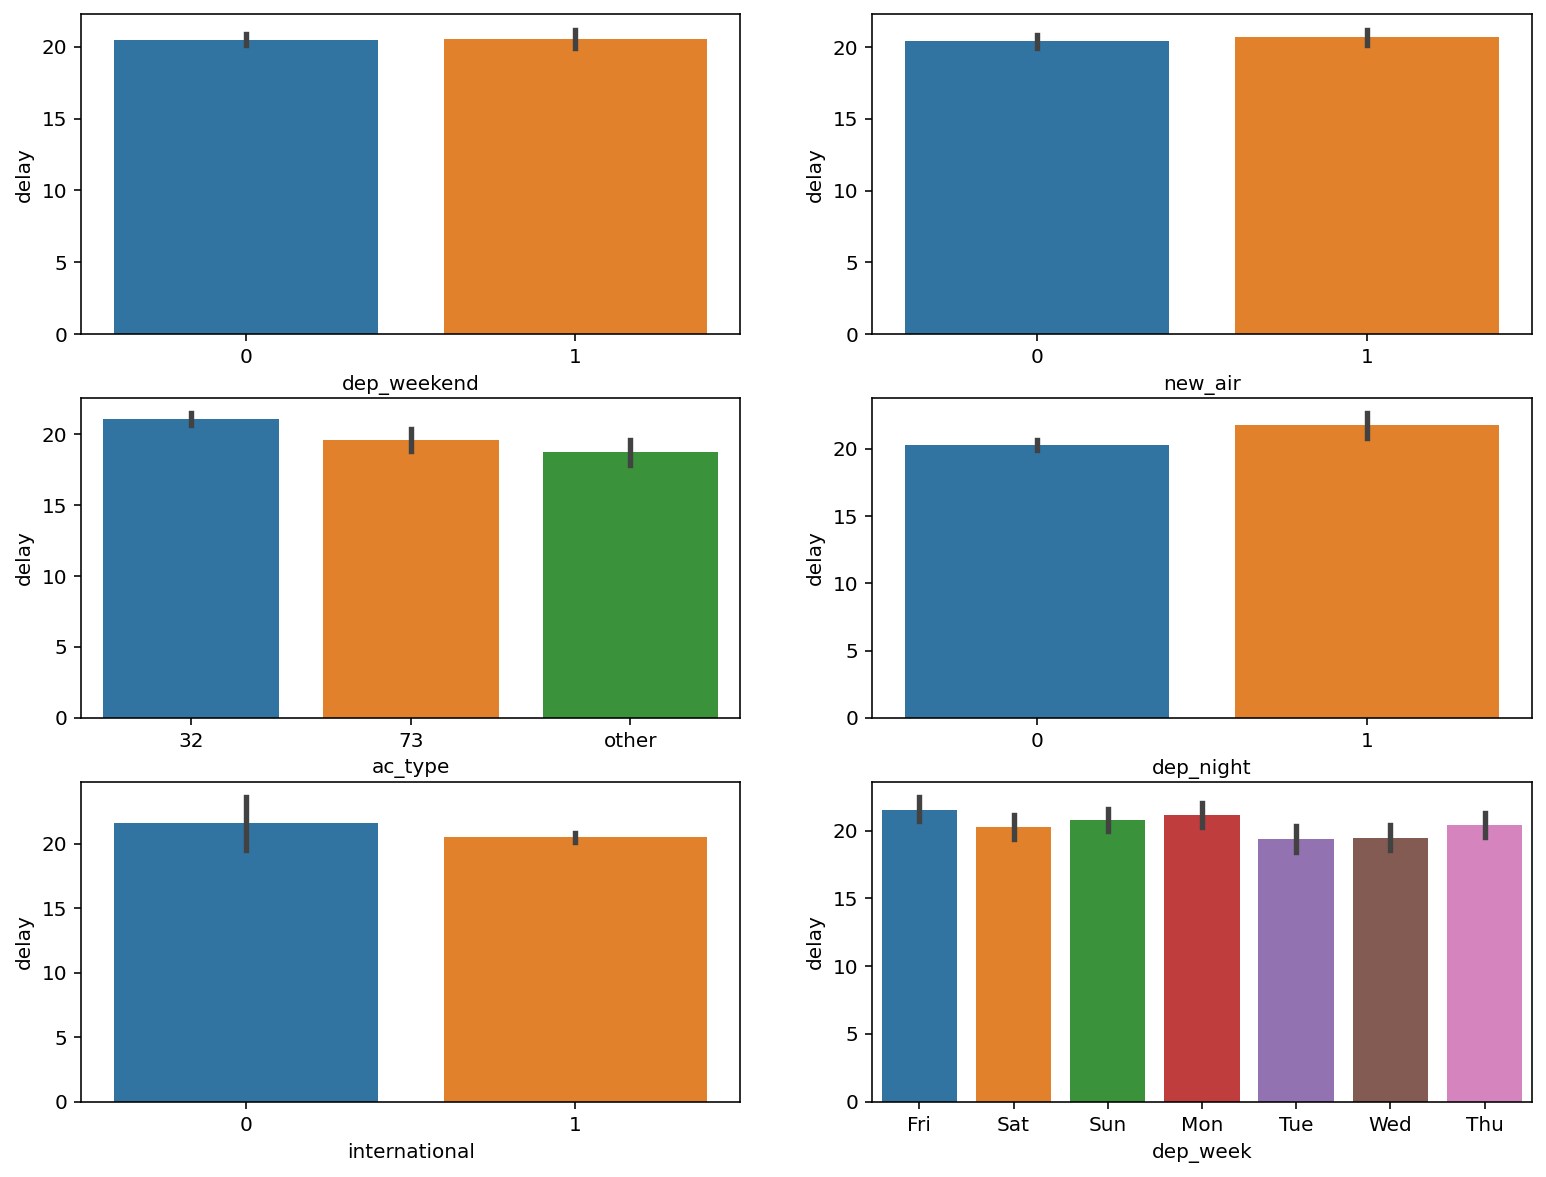

In [264]:
fig=plt.figure(figsize=(13,10))
fig.add_subplot(3,2,1)
sns.barplot(x="dep_weekend", y="delay", data=data_new) 
fig.add_subplot(3,2,2)
sns.barplot(x="new_air", y="delay", data=data_new) 
fig.add_subplot(3,2,3)
sns.barplot(x="ac_type", y="delay", data=data_new) 
fig.add_subplot(3,2,4)
sns.barplot(x="dep_night", y="delay", data=data_new) 
fig.add_subplot(3,2,5)
sns.barplot(x="international", y="delay", data=data_new)
fig.add_subplot(3,2,6)
sns.barplot(x="dep_week", y="delay", data=data_new)
# little difference

## Visualization, Modeling, Machine Learning

Build a regression model to predict how many minutes a flight will be delayed. Please explain the findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model's performance will be evaluated on mean absolute percent error.**
- **Read the test.csv file and prepare features for testing.**

In [269]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   weather           5000 non-null   int64  
 1   hobbs_meter       5000 non-null   int64  
 2   duration          5000 non-null   float64
 3   year_use          5000 non-null   int64  
 4   new_air           5000 non-null   int64  
 5   ac_type           5000 non-null   object 
 6   international     5000 non-null   int64  
 7   dep_night         5000 non-null   int64  
 8   dep_weekend       5000 non-null   object 
 9   num_lines         5000 non-null   int64  
 10  roll_dep_stn      5000 non-null   float64
 11  roll_dep_country  5000 non-null   float64
 12  delay             5000 non-null   float64
dtypes: float64(4), int64(7), object(2)
memory usage: 507.9+ KB


In [268]:
def onehot_encode(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [270]:
def preprocess_input(df):
    df = df.copy()
    for column in ['ac_type','dep_weekend']:
              df = onehot_encode(df, column = column)
      
    y = df["delay"]
    X = df.drop("delay", axis = 1)
    return X, y

In [271]:
X, y = preprocess_input(data_new)

### Random Forest

In [43]:
# Pipeline
scalar = StandardScaler()
rf = RandomForestRegressor()
pipeline = Pipeline([('transformer', scalar), ('estimator', rf)])
# CV
scores = cross_val_score(pipeline, X, y, cv = 5)
scores.mean()
# GridSearch
paramgrid = {"max_features" : range(4,12),
             "n_estimators":  range(1,100,10)} 

pipeline_grid = Pipeline([('transformer', scalar), 
                          ('estimator', GridSearchCV(rf,param_grid=paramgrid,
                                                     n_jobs=8,cv=5,scoring="neg_mean_absolute_percentage_error",refit=True))])

# pipeline_grid.fit(X=X,y=y)
# pipeline_grid[1].best_estimator_ # Show the best combination: max = 10, n_est = 2001

In [44]:
# use cross validation
rf_best = RandomForestRegressor(n_estimators=71,max_features=4)
pipeline = Pipeline([('transformer', scalar), ('estimator', rf_best)])
mape = cross_val_score(pipeline, X, y, cv =8,scoring="neg_mean_absolute_percentage_error")
r2 = cross_val_score(pipeline, X, y, cv =8,scoring="r2")
rmse = cross_val_score(pipeline, X, y, cv =8,scoring="neg_root_mean_squared_error")

In [45]:
np.abs(mape.mean())

0.8800423002418536

In [46]:
np.abs(r2.mean())

0.23287309941999995

In [47]:
np.abs(rmse.mean())

13.524849529253288

In [48]:
pipeline.fit(X,y)

Pipeline(steps=[('transformer', StandardScaler()),
                ('estimator',
                 RandomForestRegressor(max_features=4, n_estimators=71))])

Text(0.5, 1.0, 'Feature Importance')

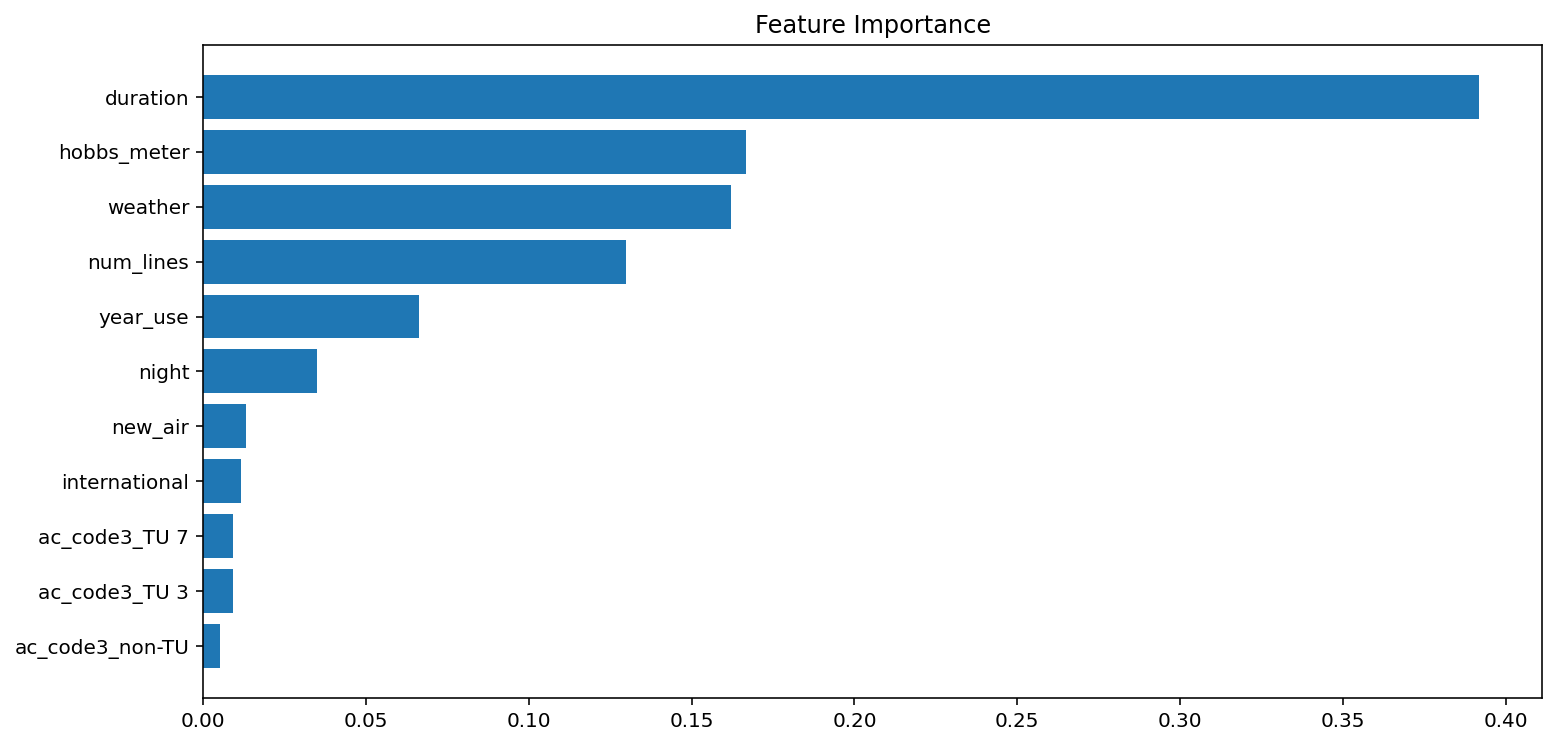

In [49]:
feature_importance = rf_best.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

In [50]:
#explainer = shap.TreeExplainer(rf_best)
#shap_values = explainer.shap_values(X)
#shap.summary_plot(shap_values, X)

In [51]:
#Loading Test data
test_data=pd.read_csv('test.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           3000 non-null   object
 1   dep_stn      3000 non-null   object
 2   arr_stn      3000 non-null   object
 3   ac_code      3000 non-null   object
 4   dep_date     3000 non-null   object
 5   arr_date     3000 non-null   object
 6   weather      3000 non-null   object
 7   hobbs_meter  3000 non-null   int64 
 8   year_man     3000 non-null   object
 9   dep_country  3000 non-null   object
 10  arr_country  3000 non-null   object
dtypes: int64(1), object(10)
memory usage: 257.9+ KB


In [52]:
def clean(data):
    data['dep_date'] = data['dep_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    data['arr_date'] = data['arr_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H.%M.%S'))

    order_map = {'sunny': -1, 'cloudy': 0, 'windy':0, 'foggy':0, 'rainy':1,'stormy':2}
    data['weather'] = data['weather'].map(order_map)

    data['year_man'] = pd.to_datetime(data['year_man'])
    data['year_man'] = data['year_man'].dt.year
    data['year_use'] = 2022-data['year_man']
    data['new_air'] = np.where(data['year_use']<=15, 1, 0)

    data['ac_code3'] = np.where(data['ac_code'].str.contains('TU 3'),'TU 3',data['ac_code'])
    data['ac_code3'] = np.where(data['ac_code3'].str.contains('TU 7'),'TU 7',data['ac_code3'])
    S1 = ~data['ac_code3'].str.contains('TU 3')
    S2 = ~data['ac_code3'].str.contains('TU 7')
    data['ac_code3'] = np.where(S1&S2,'non-TU',data['ac_code3'])

    S3 = data['dep_country'] != data['arr_country']
    data['international'] = np.where(S3,1,0)

    data['duration'] = (data['arr_date'] - data['dep_date'])
    data['duration'] = data['duration'].dt.seconds/3600
    data['duration'] = round(data['duration'],1)

    data['night'] = ~data['dep_date'].dt.hour.isin(np.arange(6,18))
    order_map2 = {False: 0, True: 1}
    data['night'] = data['night'].map(order_map2)

    # data['pre_avg_delay'] = data['delay'].rolling(30, min_periods = 1, center = True).mean()
    # data['pre_avg_delay'] = round(data['pre_avg_delay'])

    data['num_lines'] = data.groupby(['dep_stn'])['arr_stn'].transform('nunique')

    # select the features
    data = data[['weather','hobbs_meter','year_use','new_air','ac_code3',
                          'international','duration','night','num_lines']]

    return data

In [53]:
test_data_new = clean(test_data)


**Describe the most important features of the model to management.**

> #### Task:
- **Visualize the top 10 features and their feature importance.**


In [54]:
def preprocess_input_test(df):
    df = df.copy()
    for column in ['ac_code3']:
        df = onehot_encode(df, column = column)
    return df
test_data_new = preprocess_input_test(test_data_new)

In [55]:
scalar = StandardScaler()
scalar.fit(test_data_new)
test_preds = rf_best.predict(test_data_new)

> #### Task:
- **Submit the predictions on the test dataset using the optimized model** <br/>
    For each record in the test set (`test.csv`), predict how many minutes a flight will be delayed. Submit a CSV file with a header row and one row per test entry.

The file (`submissions.csv`) should have exactly 2 columns:
   - **id**
   - **delay**

In [56]:
submission_df = pd.DataFrame({'id': test_data.id,
                      'delay': test_preds})

In [57]:
#Submission
submission_df.to_csv('submissions.csv',index=False)